In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from xgboost import XGBClassifier

In [13]:
#Reading the file and splitting our target column
df = pd.read_csv (r'bank-additional.csv', sep = ';', engine= 'python')   

tussen = df[["y"]]
target = tussen.copy()
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)

In [14]:
#Encoding all the catergorical variables and deleting them from the old dataframe
categories = ['marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
df_encoded = pd.get_dummies(df['job'], prefix='job', drop_first=False)
df_encoded.insert(0, 'ID', range(0, len(df_encoded)))
del df['job']

for x in categories:
    df_encoded_tussen = pd.get_dummies(df[x], prefix=x, drop_first=True)
    df_encoded_tussen.insert(0, 'ID', range(0, len(df_encoded_tussen)))
    df_encoded = pd.merge(df_encoded, df_encoded_tussen, on = 'ID', how = 'outer')
    del df[x]

df.insert(0, 'ID', range(0, len(df)))
features = pd.merge(df_encoded, df, on = 'ID', how = 'outer')
y = pd.get_dummies(target, drop_first=True)
del features['ID']

In [19]:
#Boosting the tree and predicting with ROC curve and classification reports
def gradient_boosted_tree(features, targets):
    train_features, test_features, train_targets, test_targets = train_test_split(features, y.values.ravel(), test_size=0.2,
                                                                                  random_state=23)
    ensemble = GradientBoostingClassifier(max_depth=1, n_estimators=1000 ,random_state=23).fit(
        train_features, train_targets)
    predictions = ensemble.predict(test_features)
    
    k = 10
    kf = KFold(n_splits=k, shuffle = True, random_state = 23)

    
    dt_scores = cross_val_score(ensemble, train_features, train_targets, scoring ='accuracy' ,cv = kf)
    print("mean cross validation score: {}".format(np.round(np.mean(dt_scores),3)))
    print("score without cv: {}".format(np.round(ensemble.score(train_features, train_targets),3)))
    
    #print(r2_score(test_targets, predictions))
    #print(ensemble.score(test_features, test_targets))
    
    print("Confusion Matrix:")
    print(confusion_matrix(test_targets, predictions))

    print("Classification Report")
    print(classification_report(test_targets, predictions))
    
    #Beginning the plotting of ROC-curve
    pred_prob = ensemble.predict_proba(test_features)
    fpr, tpr, thresh = roc_curve(test_targets, pred_prob[:,1], pos_label=1)
    
    #Plot roc curves
    plt.plot(fpr, tpr, linestyle='--',color='orange', label='Boosted Trees')

    # title
    plt.title('ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')

    plt.legend(loc='best')
    plt.savefig('ROC',dpi=300)
    plt.show();
    
    #AUC Score
    auc_score = roc_auc_score(test_targets, pred_prob[:,1])
    print("AUC Score: " + str(np.round(auc_score , 3)))
    
    #Log-loss function
    print("Log-Loss: " + str(np.round(log_loss(test_targets, predictions),3)))

Confusion Matrix:
[[702  13]
 [ 61  48]]
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       715
           1       0.79      0.44      0.56       109

    accuracy                           0.91       824
   macro avg       0.85      0.71      0.76       824
weighted avg       0.90      0.91      0.90       824



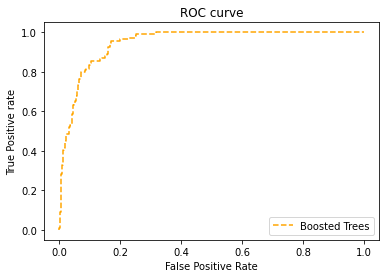

AUC Score: 0.948
Log-Loss: 3.102


In [20]:
gradient_boosted_tree(features, y.values.ravel())